This is another challenge where your data is stored in a JSON file.
Analyzing user behavior within the same session is often crucial. Clustering users based on their
browsing behavior is probably the most important step if you want to personalize your site.

The goal of this challenge is to `build the foundation of personalization by indentifying searches likely to happen together and cluster users based on their session searches.`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

#import pandas_profiling as pp
from collections import Counter
from sklearn.preprocessing import normalize

# Load Dataset

In [2]:
data = pd.read_json('../DS_Challenges/Json_City_Similarities/json_city_similarities.json')
data.head()

,session_id,unix_timestamp,cities,user
0,[D258NVMV202LS],[1442640552],"[San Jose CA, Montreal QC]","[[{'user_id': 5749, 'joining_date': '2015-04-0..."
1,[TDG10UKG7I4LR],[1432110137],[New York NY],"[[{'user_id': 10716, 'joining_date': '2015-03-..."
2,[OH4ZDIGN9BLQS],[1437049311],"[Montreal QC, Quebec QC]","[[{'user_id': 2941, 'joining_date': '2015-03-1..."
3,[CWHIAYKQ7RA28],[1432215908],[Chicago IL],"[[{'user_id': 2164, 'joining_date': '2015-03-2..."
4,[GI8GZJAWAC80P],[1443556226],"[Toronto ON, Houston TX]","[[{'user_id': 10493, 'joining_date': '2015-03-..."


In [3]:
data['unix_timestamp'][0][0]

1442640552

In [4]:
def parse_json(data):
    '''function to parse json file'''
    user_id = []
    joining_date = []
    country = []
    city = []
    timestamp = []
    session = []
    
    for i in range(len(data)):
        user_id.append(data['user'][i][0][0]['user_id'])
        joining_date.append(data['user'][i][0][0]['joining_date'])
        country.append(data['user'][i][0][0]['country'])
        city.append(data['cities'][i][0])
        timestamp.append(data['unix_timestamp'][i][0])
        session.append(data['session_id'][i][0])
    df = pd.DataFrame({'session_id':session,'unix_timestamp':timestamp,'cities':city,
                       'user_id':user_id,'joining_date':joining_date,'country':country})
    return df

In [5]:
data = parse_json(data)
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   session_id      20022 non-null  object
 1   unix_timestamp  20022 non-null  int64 
 2   cities          20022 non-null  object
 3   user_id         20022 non-null  int64 
 4   joining_date    20022 non-null  object
 5   country         20022 non-null  object
dtypes: int64(2), object(4)
memory usage: 938.7+ KB


In [7]:
data.describe(include='all')

,session_id,unix_timestamp,cities,user_id,joining_date,country
count,20022,2.002200e+04,20022,20022.000000,20022,20022
unique,20022,NaN,1293,NaN,35,7
top,23QJXA6K1JADZ,NaN,New York NY,NaN,2015-03-14,US
freq,1,NaN,2296,NaN,784,3772
mean,NaN,1.435142e+09,NaN,5503.009040,NaN,NaN
std,NaN,5.007389e+06,NaN,3186.296649,NaN,NaN
min,NaN,1.425169e+09,NaN,1.000000,NaN,NaN
25%,NaN,1.430902e+09,NaN,2768.250000,NaN,NaN
50%,NaN,1.435147e+09,NaN,5513.000000,NaN,NaN
75%,NaN,1.439485e+09,NaN,8275.750000,NaN,NaN


In [8]:
#pp.ProfileReport(data)

# QUESTION 1

There was a bug in the code and one country didn't get logged. It just shows up as an
empty field (""). 

Can you guess which country was that? How?

In [9]:
data['country'].value_counts()

US    3772
UK    3754
DE    3741
      2769
FR    2341
IT    1843
ES    1802
Name: country, dtype: int64

Given the current dataset, since there are little information about the dataset, one information that could be used to guess the country is the search time. Since people in different countries will search in similar local time, we can use this information to guess the country.

In [10]:
# extract time and hour
data['time'] = pd.to_datetime(data['unix_timestamp'],unit = 's')
data['hour'] = data['time'].dt.hour
data.head(3)

,session_id,unix_timestamp,cities,user_id,joining_date,country,time,hour
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12


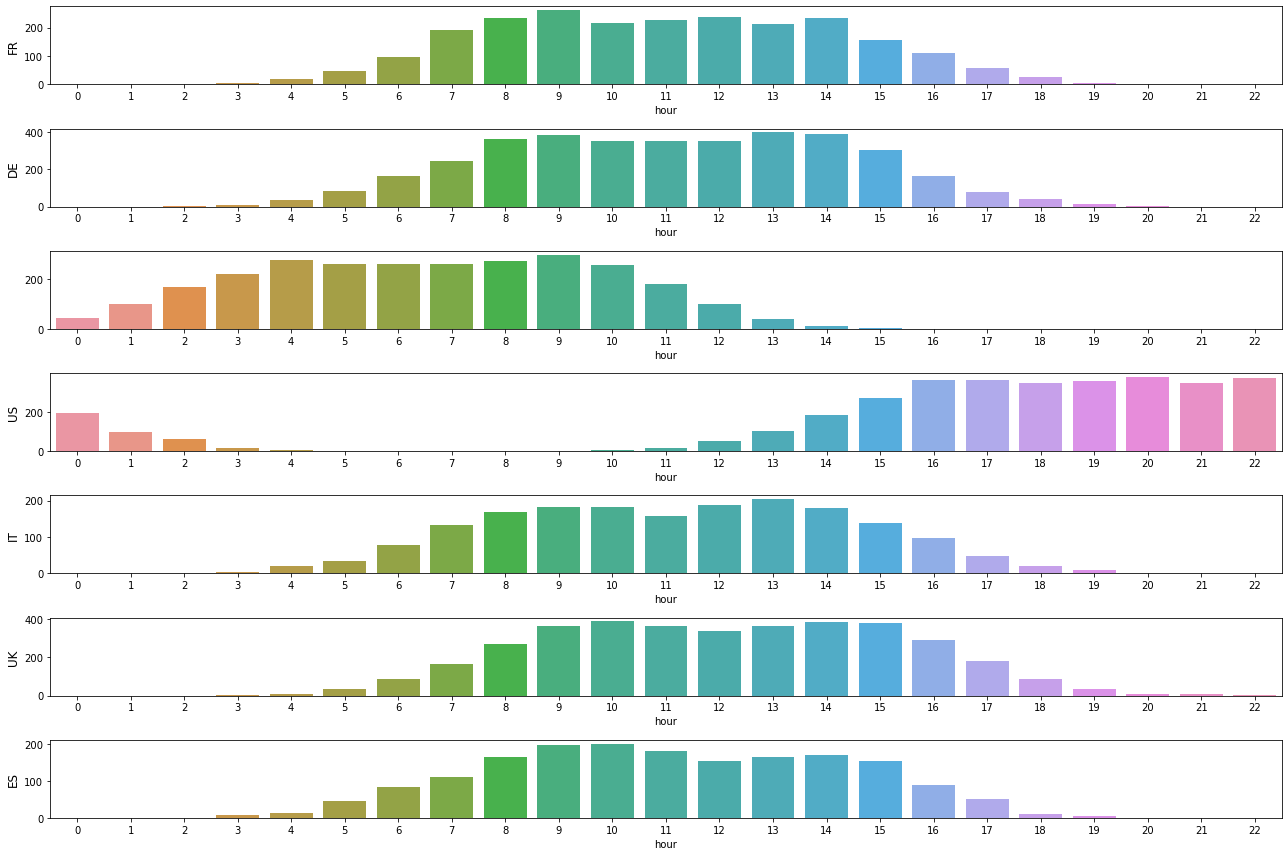

In [11]:
# visualization
fig, ax = plt.subplots(nrows = 7, ncols = 1, figsize = (18,12))
countries = data['country'].unique()
order = list(range(0, 23))
for i in range(len(countries)):
    sns.countplot(data=data.loc[data['country']==countries[i]], x = 'hour', ax=ax[i], order = order)
    ax[i].set_ylabel(countries[i], fontsize=12)
plt.tight_layout()

Based on above figure, we can see that, for the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with UK. Based on the geographic locations of each country, it seems that this missing country is in `Asia`. Possible countries include `China` and `Japan`. 

# Question 2
For each city, find the most likely city to be also searched for within the same session.

In [12]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,time,hour
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19


## Answer question 2

my basic idea to solve this problem is:
1. build the city-user matrix. Value $[i,j]$ in the matrix represents the number of times that user j search for city i
2. then calculate cosine similarity between any two city vectors, get a similarity matrix
3. similarity[i,j] represents the similarity between i-th and j-th city
4. sort i-th row or column to get the top similar cities with i-th city

In [13]:
# Step 1: build the City-User matrix

def city_counts(data):
    cities = [city for cities in data['cities'].str.split(', ') for city in cities]
    # calculate # of users in each city
    c = Counter(cities)
    return pd.Series(c)

city_user = data.groupby('user_id').apply(city_counts).unstack(fill_value=0)
city_user = city_user.transpose()
city_user

user_id,1,2,4,6,7,8,9,10,11,12,...,10989,10990,10991,10992,10993,10995,10996,10998,10999,11000
Anaheim CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arlington TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atlanta GA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Austin TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bakersfield CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Victoria BC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Virginia Beach VA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASHINGTON DC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Wichita KS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Step 2: build city-city similarity matrix

# make each row unit-norm, then dot-product is equivalent to cosine
city_user_norm = normalize(city_user, axis=1)  # normalize the city-user matrix


similarity = np.dot(city_user_norm, city_user_norm.T)  # calculate the similarity matrix
similarity_df = pd.DataFrame(similarity, index=city_user.index, columns=city_user.index)

similarity_df.head()


,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.034157,0.024398,0.022908,0.057505,0.027524,0.00000,0.017528,0.009858,0.024836,...,0.005832,0.082593,0.015430,0.000000,0.043104,0.021289,0.018898,0.006855,0.024398,0.021277
Arlington TX,0.034157,1.000000,0.016667,0.245171,0.015713,0.016116,0.00000,0.023947,0.033672,0.027146,...,0.007968,0.041841,0.021082,0.073030,0.044169,0.011635,0.000000,0.000000,0.066667,0.000000
Atlanta GA,0.024398,0.016667,1.000000,0.000000,0.039284,0.000000,0.46291,0.000000,0.000000,0.008483,...,0.019920,0.009509,0.000000,0.000000,0.015775,0.000000,0.000000,0.000000,0.000000,0.000000
Austin TX,0.022908,0.245171,0.000000,1.000000,0.012295,0.016814,0.00000,0.014053,0.042155,0.026551,...,0.006235,0.051589,0.000000,0.028571,0.052664,0.027311,0.000000,0.007328,0.000000,0.007582
Bakersfield CA,0.057505,0.015713,0.039284,0.012295,1.000000,0.012662,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.026896,0.000000,0.000000,0.004957,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
# Step 3: find the top-k most similar cities
def find_topk(s,k=1):
    # [0] must be itself
    topks = s.sort_values(ascending=False)[1:k+1].index.values
    return pd.Series(topks,index = ["similar#{}".format(i) for i in range(1,k+1)])

most_similar_cities = similarity_df.apply(find_topk,axis=1)

In [17]:
most_similar_cities = similarity_df.apply(find_topk,k=3,axis=1)
most_similar_cities

,similar#1,similar#2,similar#3
Anaheim CA,Santa Ana CA,Long Beach CA,Riverside CA
Arlington TX,Fort Worth TX,Plano TX,Dallas TX
Atlanta GA,Birmingham AL,Charlotte NC,Raleigh NC
Austin TX,San Antonio TX,Houston TX,Fort Worth TX
Bakersfield CA,Fresno CA,Charlotte NC,Raleigh NC
...,...,...,...
Victoria BC,Seattle WA,Vancouver BC,Portland OR
Virginia Beach VA,Chesapeake VA,Norfolk VA,WASHINGTON DC
WASHINGTON DC,Baltimore MD,Chesapeake VA,Virginia Beach VA
Wichita KS,Lincoln NE,Kansas City MO,Oklahoma City OK


# Question 3

Travel sites are browsed by two kinds of users. 

1. Users who are actually planning a trip and 
2. Users who just dream about a vacation. 

The first ones have obviously a much higher
purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). 

Based on this idea, come up with an `algorithm` that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

## Answer to question 3

For this question, one way is to actually calculate the geographic distance for actual searched cities. However, this solution is not very practical for this small project. Another choice is to **calculate the distance based on the city-city similarity in Question 2.**

1. calculate the average of city-city similarity distance between each two cities in one session
2. plot the distribution of all sessions' avg distance and set a cutoff distance.
3. every session whose avg distance is below the cutoff will be included to the high-intent group, otherwise low-intent group.

In [18]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,time,hour
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19


In [27]:
similarity_df

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.034157,0.024398,0.022908,0.057505,0.027524,0.00000,0.017528,0.009858,0.024836,...,0.005832,0.082593,0.015430,0.000000,0.043104,0.021289,0.018898,0.006855,0.024398,0.021277
Arlington TX,0.034157,1.000000,0.016667,0.245171,0.015713,0.016116,0.00000,0.023947,0.033672,0.027146,...,0.007968,0.041841,0.021082,0.073030,0.044169,0.011635,0.000000,0.000000,0.066667,0.000000
Atlanta GA,0.024398,0.016667,1.000000,0.000000,0.039284,0.000000,0.46291,0.000000,0.000000,0.008483,...,0.019920,0.009509,0.000000,0.000000,0.015775,0.000000,0.000000,0.000000,0.000000,0.000000
Austin TX,0.022908,0.245171,0.000000,1.000000,0.012295,0.016814,0.00000,0.014053,0.042155,0.026551,...,0.006235,0.051589,0.000000,0.028571,0.052664,0.027311,0.000000,0.007328,0.000000,0.007582
Bakersfield CA,0.057505,0.015713,0.039284,0.012295,1.000000,0.012662,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.026896,0.000000,0.000000,0.004957,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Victoria BC,0.021289,0.011635,0.000000,0.027311,0.000000,0.009375,0.00000,0.020896,0.011753,0.216148,...,0.000000,0.058638,0.000000,0.000000,0.323015,1.000000,0.000000,0.000000,0.000000,0.016911
Virginia Beach VA,0.018898,0.000000,0.000000,0.000000,0.000000,0.187256,0.00000,0.023187,0.000000,0.000000,...,0.000000,0.004911,0.000000,0.000000,0.000000,0.000000,1.000000,0.290191,0.000000,0.000000
WASHINGTON DC,0.006855,0.000000,0.000000,0.007328,0.000000,0.400003,0.00000,0.025232,0.009461,0.009534,...,0.022389,0.037406,0.000000,0.000000,0.026594,0.000000,0.290191,1.000000,0.000000,0.013613
Wichita KS,0.024398,0.066667,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.182574,0.010516,0.000000,0.000000,0.000000,1.000000,0.000000


In [74]:
def cal_avg_distance(cities,similar2dist):
    '''
    fuction to calculate the average distance of each two cities in one session.
    
    input: 
        cities: a list of cities included in the search
        similar2dist: a function which maps similarity to distance
    return: 
        distance: distance among cities in the search
    '''
    cities = cities.split(', ')
    city_nums = len(cities)
    sumdist = 0
    
    # if city_nums=1, sumdist=0, distance=0
    for i in range(city_nums-1):
        city1 = cities[i]
        for j in range(i+1,city_nums):
            city2 = cities[j]
            similar = similarity_df.loc[city1, city2]
            dist = similar2dist(similar)
            
            sumdist += dist
                
    return sumdist/city_nums        

In [78]:
data['distance'] = data['cities'].map(lambda cities: cal_avg_distance(cities,lambda s: np.sqrt(1-s*s)))

In [79]:
data.head(3)

,session_id,unix_timestamp,cities,user_id,joining_date,country,time,hour,distance
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5,0.497705
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8,0.000000
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12,0.485447


/Users/yli/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


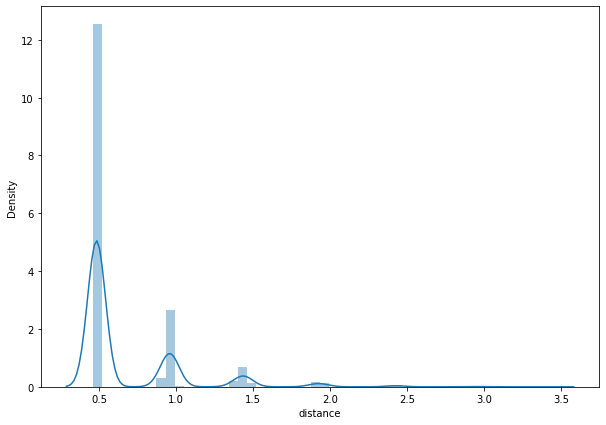

In [81]:
plt.figure(figsize=(10,7))
sns.distplot(data.loc[data['distance']!=0]['distance'])
plt.show()

<AxesSubplot:xlabel='distance'>

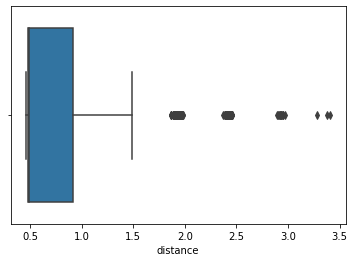

In [82]:
sns.boxplot(data=data.loc[data['distance']!=0], x = 'distance')

In [83]:
data.loc[data['distance']!=0]['distance'].describe()

count    9469.000000
mean        0.663485
std         0.358703
min         0.459572
25%         0.478292
50%         0.491046
75%         0.913387
max         3.410431
Name: distance, dtype: float64

according to above plots, I decide to choose <span style='color:orange;font-size:1.2em'>distance=0.9 as the cutoff between 'high intent search' and 'low intent search'</span>. if the distance is higher than 0.9, then I classify such search as 'low intent'.

In [85]:
dist_cutoff = 0.9
distances = data['distance']
print ('percentage of low intent search:{:.2f}%'.format((distances>dist_cutoff).mean() * 100))

percentage of low intent search:12.31%


In [87]:
low_intent = data.loc[distances>dist_cutoff,['session_id','cities']]
low_intent

,session_id,cities
27,0SC7QIZFOEFTH,"Philadelphia PA, Newark NJ, New York NY"
57,TWW9KML49LF5O,"Montreal QC, Boston MA, New York NY"
58,KXRXFT12NU45W,"Toronto ON, Buffalo NY, Saint Catharines-Niaga..."
62,SOWI201JPGWC7,"Edmonton AB, Calgary AB, Vancouver BC"
64,FVV9Q91UDVCIH,"San Diego CA, Santa Ana CA, Anaheim CA"
...,...,...
19997,I3KZHUYNRCM94,"New York NY, Jersey City NJ, Newark NJ"
20004,TH4KXAOKPMAQ6,"Phoenix AZ, Glendale AZ, Chandler AZ"
20011,PGW9D5EAUNPSE,"Chicago IL, Indianapolis IN, Fort Wayne IN"
20013,28OEJGDOCVT93,"Dallas TX, Oklahoma City OK, Plano TX"
